# Imports & Setup

In [37]:
#Imported libariries
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain, MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import hamming_loss,accuracy_score, f1_score
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Preprocessing

In [38]:

def importText(filePath):
    df = pd.read_csv(filePath)
    df = df[df['genres'] != '\\N']
    return df[["genres", "Description"]]

# Used to clean description text and returns un-tokenized
def cleanText(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in words]
    cleaned_text = " ".join(tokens)
    return cleaned_text

# Convert genres to binary multi-label format
def genreToBinary(df, genre_list):
    binary_matrix = []
    for genres in df['genres']:
        genre_vector = [1 if genre in genres.split(",") else 0 for genre in genre_list]
        binary_matrix.append(genre_vector)
    return pd.DataFrame(binary_matrix, columns=genre_list)

#Visualization

In [39]:
#Method to plot number of movies per genre
def plot_movies_per_genre(Y, genre_list):
    # Sum up the 1s for each genre
    genre_counts = Y.sum(axis=0)

    # Plotting
    plt.figure(figsize=(12, 6))
    genre_counts.plot(kind='bar', color='skyblue')
    plt.title('Number of Movies per Genre')
    plt.xlabel('Genre')
    plt.ylabel('Number of Movies')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot true vs. predicted heatmap
def plot_true_vs_pred_heatmap(Y_test_array, Y_pred, genre_list):
    acc_per_genre = np.mean(Y_test_array == Y_pred, axis=0)

    plt.figure(figsize=(len(genre_list) * 0.7, 8))

    sns.heatmap(
        acc_per_genre.reshape(1, -1),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        xticklabels=genre_list,
        yticklabels=['Accuracy'],
    )

    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(fontsize=12)
    plt.title('Per-Genre Accuracy', fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n\n')

#Method to get word clouds
def plot_wordcloud(text_list, title):
    print("Word cloud")
    text = " ".join(text_list)
    cloud = WordCloud(
        stopwords=STOPWORDS,
        background_color='black',
        collocations=False,
        width=2500,
        height=1800
    ).generate(text)

    plt.figure(figsize=(10, 10))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=24)
    plt.show()
    print('\n\n')

#Plot bar chart of hamming loss
def plot_hamming_loss(Y_test_array, Y_pred, genre_list):
    hamming_losses = [hamming_loss(Y_test_array[:, i], Y_pred[:, i]) for i in range(Y_test_array.shape[1])]

    plt.figure(figsize=(12, 6))
    plt.bar(genre_list, hamming_losses, color='lightcoral')
    plt.xlabel('Genre')
    plt.ylabel('Hamming Loss')
    plt.title('Hamming Loss per Genre')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Classifier Chain Model (Random Forest Base Classifier)

In [40]:
def train_and_evaluate_classifier_chain(X_train, X_test, Y_train, Y_test, genre_list, threshold=0.4):
    # Initialize Classifier Chain with RandomForest as the base classifier
    base_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    chain_model = ClassifierChain(base_estimator=base_clf, order='random', random_state=42)

    # Train the Classifier Chain
    chain_model.fit(X_train, Y_train)

    # Predict probabilities
    Y_proba = chain_model.predict_proba(X_test)

    # Apply threshold manually
    Y_pred = (Y_proba >= threshold).astype(int)

    print(f"Classifier Chain Report")

    # Per-genre (per-label) Accuracy & F1-Score
    print("\nPer-genre (per-label) Accuracy, F1-Score, and Hamming Loss:")
    print("-" * 60)
    for idx, genre in enumerate(genre_list):
        y_true = Y_test.iloc[:, idx].values
        y_pred = Y_pred[:, idx]
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        hamming = hamming_loss(y_true, y_pred)
        print(f"{genre:20s}  {acc:.4f}   {f1:.4f}   {hamming:.4f}")

    # Overall F1-Score (micro-average)
    overall_f1 = f1_score(Y_test.values, Y_pred, average='micro', zero_division=0)
    print(f"\nOverall F1-Score (micro-average): {overall_f1:.4f}")

    # Overall Hamming Loss
    overall_hamming = hamming_loss(Y_test.values, Y_pred)
    print(f"Overall Hamming Loss: {overall_hamming:.4f}")

    # Overall Accuracy score
    overall_accuracy = accuracy_score(Y_test.values, Y_pred)
    print(f"Overall Accuracy: {overall_accuracy:.4f}\n")

    # visualize per-genre Hamming Loss
    plot_hamming_loss(Y_test.values, Y_pred, genre_list)

    # visualize per-genre accuracy heatmap
    plot_true_vs_pred_heatmap(Y_test.values, Y_pred, genre_list)

    return chain_model

# Logisitic Regression Model

In [41]:
def train_and_evaluate_logistic_multioutput(X_train, X_test, Y_train, Y_test, genre_list, max_iter=5000):
    # Wrap LogisticRegression for multi-label classification
    base_clf = LogisticRegression(max_iter=max_iter, class_weight='balanced')
    multi_clf = MultiOutputClassifier(base_clf)

    # Train
    multi_clf.fit(X_train, Y_train)

    # Predict
    Y_pred = multi_clf.predict(X_test)

    print("Logistic Regression Report")

    # Evaluate
    #print(classification_report(Y_test, Y_pred, target_names=genre_list, zero_division=0))

    # Per-genre (per-label) Accuracy & F1-Score
    print("\nPer-genre (per-label) Accuracy, F1-Score, and Hamming Loss:")
    print("-" * 60)
    for idx, genre in enumerate(genre_list):
        y_true = Y_test.iloc[:, idx].values
        y_pred = Y_pred[:, idx]
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        hamming = hamming_loss(y_true, y_pred)
        print(f"{genre:20s}  {acc:.4f}   {f1:.4f}   {hamming:.4f}")


    # Overall F1-Score (micro-average)
    overall_f1 = f1_score(Y_test.values, Y_pred, average='micro', zero_division=0)
    print(f"\nOverall F1-Score (micro-average): {overall_f1:.4f}")

    # Overall Hamming Loss
    overall_hamming = hamming_loss(Y_test.values, Y_pred)
    print(f"Overall Hamming Loss: {overall_hamming:.4f}")

    #Overall Accuracy score
    overall_accuracy = accuracy_score(Y_test.values, Y_pred)
    print(f"Overall Accuracy: {overall_accuracy:.4f}\n")

    # visualize per-genre Hamming Loss
    plot_hamming_loss(Y_test.values, Y_pred, genre_list)

    # visualize per-genre accuracy heatmap
    plot_true_vs_pred_heatmap(Y_test.values, Y_pred, genre_list)

    return multi_clf

# Deep Learning -> Multi Layer Perceptron Model

In [42]:
def train_and_evaluate_mlp_multioutput(X_train, X_test, Y_train, Y_test, genre_list):
   # Initialize MLP with some reasonable starting parameters
    base_clf = MLPClassifier(hidden_layer_sizes=(128, 64),
                             activation='relu',
                             solver='adam',
                             max_iter=50,
                             early_stopping= True,
                             random_state=42)

    # Wrap MLP for multi-label classification
    multi_clf = MultiOutputClassifier(base_clf)

    # Train
    multi_clf.fit(X_train, Y_train)

    print("MLP Multioutput Report")

    # Predict
    Y_pred = multi_clf.predict(X_test)

    # Per-genre (per-label) Accuracy & F1-Score
    print("\nPer-genre (per-label) Accuracy, F1-Score, and Hamming Loss:")
    print("-" * 60)
    for idx, genre in enumerate(genre_list):
        y_true = Y_test.iloc[:, idx].values
        y_pred = Y_pred[:, idx]
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        hamming = hamming_loss(y_true, y_pred)
        print(f"{genre:20s}  {acc:.4f}   {f1:.4f}   {hamming:.4f}")


    # Overall F1-Score (micro-average)
    overall_f1 = f1_score(Y_test.values, Y_pred, average='micro', zero_division=0)
    print(f"\nOverall F1-Score (micro-average): {overall_f1:.4f}")

    # Overall Hamming Loss
    overall_hamming = hamming_loss(Y_test.values, Y_pred)
    print(f"Overall Hamming Loss: {overall_hamming:.4f}")

    #Overall Accuracy score
    overall_accuracy = accuracy_score(Y_test.values, Y_pred)
    print(f"Overall Accuracy: {overall_accuracy:.4f}\n")

    # visualize per-genre Hamming Loss
    plot_hamming_loss(Y_test.values, Y_pred, genre_list)

    # visualize per-genre accuracy heatmap
    plot_true_vs_pred_heatmap(Y_test.values, Y_pred, genre_list)


    return multi_clf

# Implementation of best model

In [43]:
def predict_genres(description, vectorizer, genre_list, model, threshold=0.4):
    # Clean and vectorize
    cleaned_desc = cleanText(description)
    X_input = vectorizer.transform([cleaned_desc])

    print(f"\nMovie Description: {description}\n")

    # Get probabilities
    Y_proba = model.predict_proba(X_input)

    # Apply threshold manually
    Y_pred = (Y_proba >= threshold).astype(int)[0]  # Single prediction
    predicted_genres = [genre for genre, flag in zip(genre_list, Y_pred) if flag == 1]
    print(f"Predicted genres: {', '.join(predicted_genres) if predicted_genres else 'None'}")

# Main Pipeline

In [44]:
def main():
    FILE_PATH = "imdb_movie_data_cleaned.csv"
    df = importText(FILE_PATH)

    # Clean descriptions
    df["Cleaned_Description"] = df["Description"].astype(str).apply(cleanText)

    # Plot overall word cloud
    plot_wordcloud(df["Cleaned_Description"].tolist(), "Common Words in Movie Descriptions")

    # Genre processing
    genre_list = sorted(set(genre for sub in df["genres"].str.split(",") for genre in sub))
    Y = genreToBinary(df, genre_list)

    #Visualize data distribution
    plot_movies_per_genre(Y, genre_list)

    # Vectorize the cleaned descriptions using TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2),  min_df=10, max_df=0.7)
    X = vectorizer.fit_transform(df["Cleaned_Description"])

    # Train/Test Split- 20% test, 80% train
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Train and evaluate Classifier chain and logistic regression
    chain_model = train_and_evaluate_classifier_chain(X_train, X_test, Y_train, Y_test, genre_list)
    logistic_regression_model = train_and_evaluate_logistic_multioutput(X_train, X_test, Y_train, Y_test, genre_list)

    # Scale data for MLP
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Train and evaluate MLP
    mlp_model = train_and_evaluate_mlp_multioutput(X_train_scaled, X_test_scaled, Y_train, Y_test, genre_list)

    #Perform multi-label movie genre classification with the best model -> Classifier Chains
    sample_description = "Paranormal investigators Ed and Lorraine Warren work to help a family terrorized by a dark presence in their farmhouse. Confronting malevolent spirits and uncovering the chilling history behind the haunting, they face their most terrifying case yet"
    predict_genres(sample_description, vectorizer, genre_list, chain_model)

# Entry Point

Word cloud


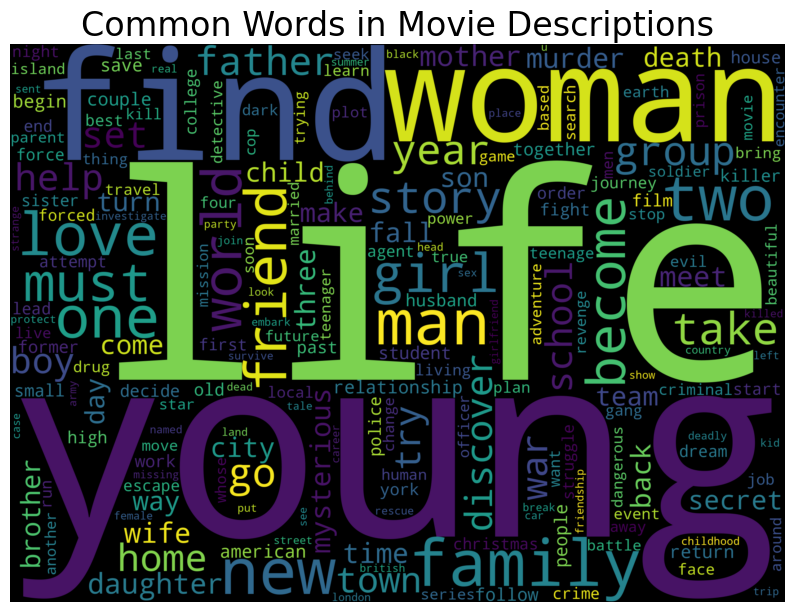

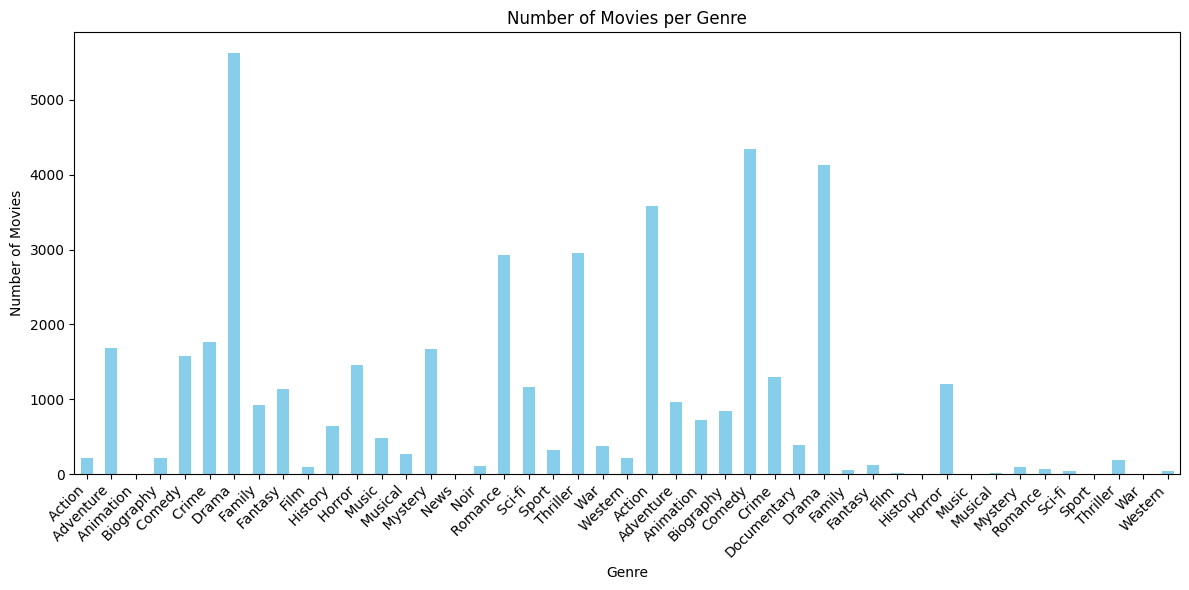

Classifier Chain Report

Per-genre (per-label) Accuracy, F1-Score, and Hamming Loss:
------------------------------------------------------------
 Action               0.9862   0.0000   0.0138
 Adventure            0.8975   0.3948   0.1025
 Animation            0.9997   0.0000   0.0003
 Biography            0.9865   0.0000   0.0135
 Comedy               0.9086   0.0350   0.0914
 Crime                0.8940   0.4576   0.1060
 Drama                0.6288   0.4315   0.3712
 Family               0.9459   0.0485   0.0541
 Fantasy              0.9337   0.1781   0.0663
 Film                 0.9936   0.0000   0.0064
 History              0.9688   0.1871   0.0312
 Horror               0.9116   0.1960   0.0884
 Music                0.9740   0.3816   0.0260
 Musical              0.9851   0.0000   0.0149
 Mystery              0.8964   0.3094   0.1036
 News                 1.0000   0.0000   0.0000
 Noir                 0.9934   0.0000   0.0066
 Romance              0.8340   0.4823   0.1660
 Sci-fi 

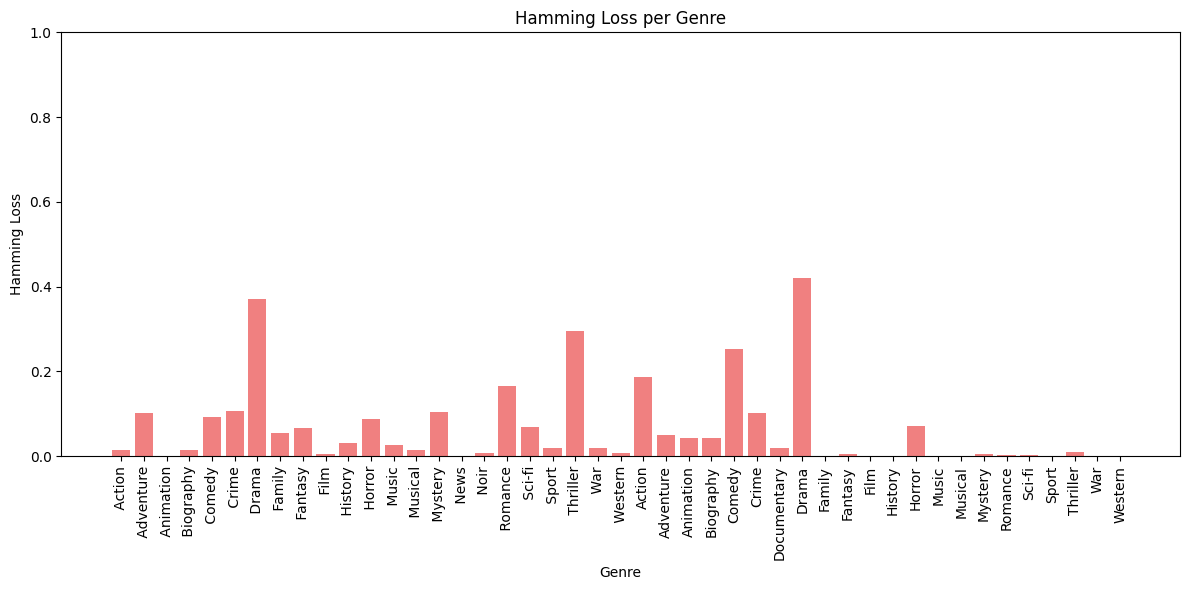

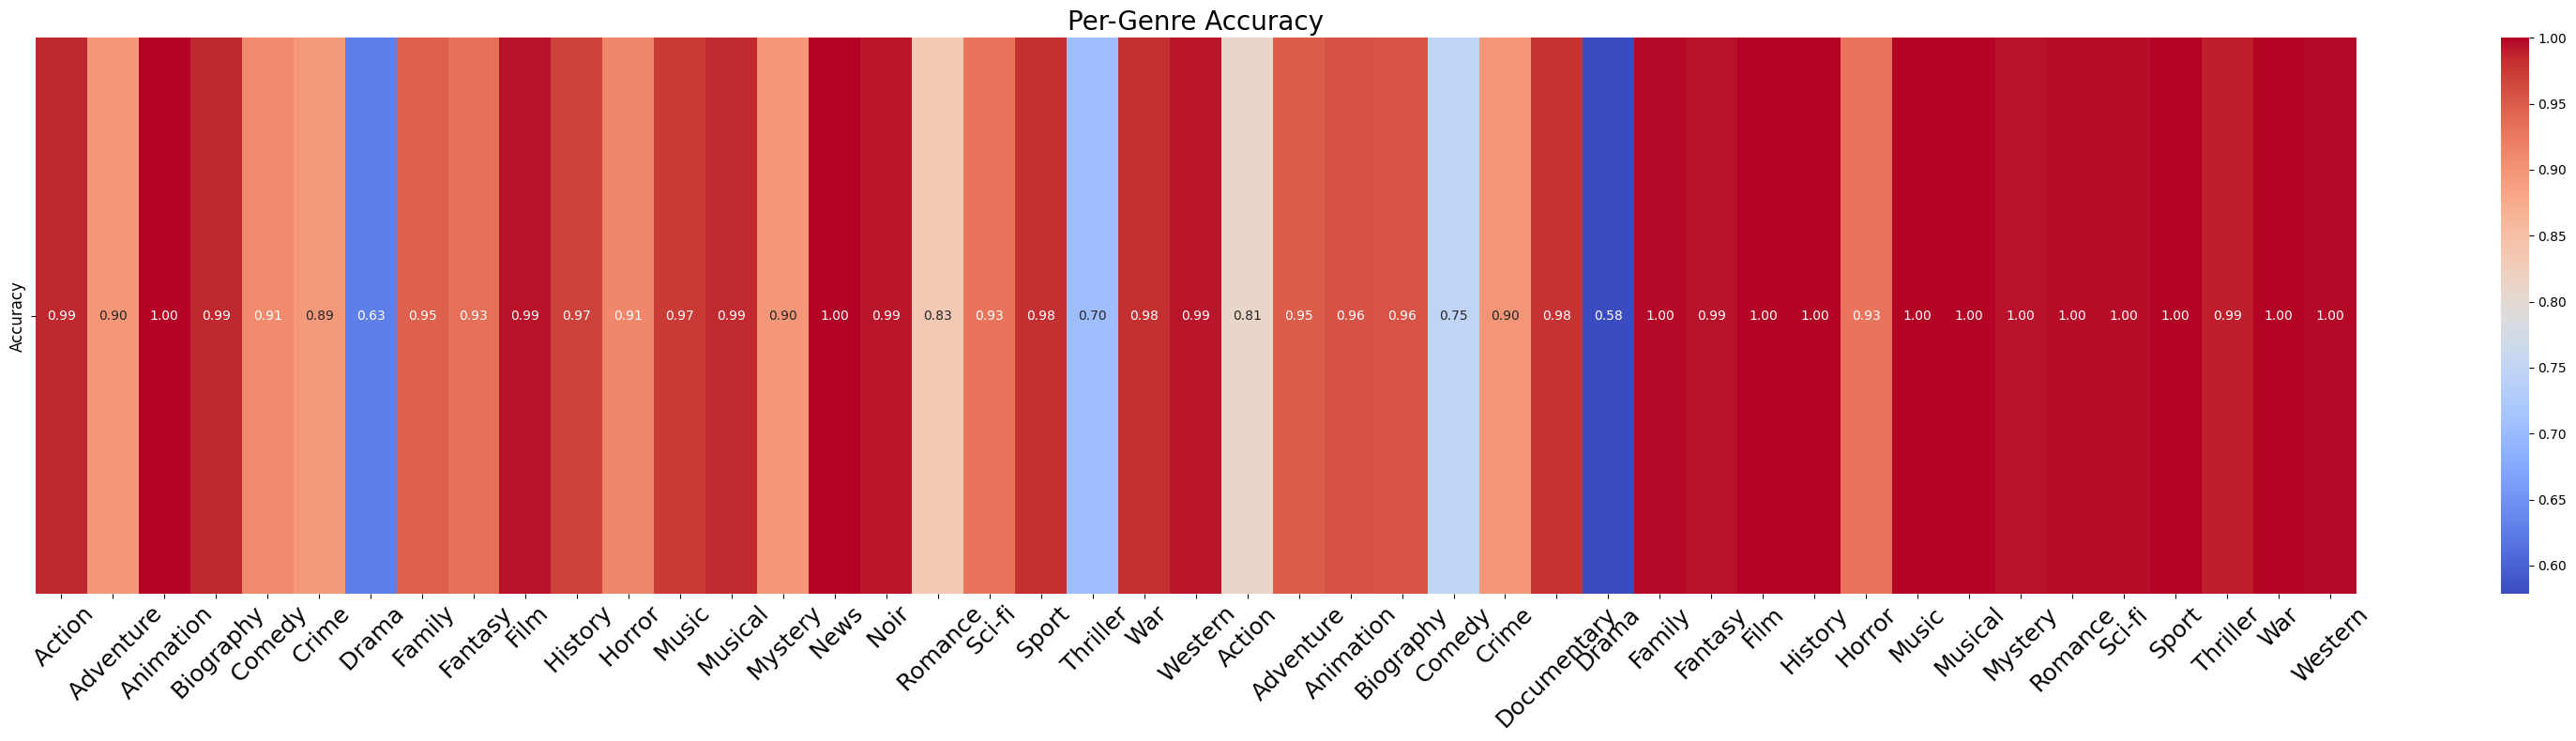




Logistic Regression Report

Per-genre (per-label) Accuracy, F1-Score, and Hamming Loss:
------------------------------------------------------------
 Action               0.9638   0.1656   0.0362
 Adventure            0.8498   0.4483   0.1502
 Animation            0.9997   0.0000   0.0003
 Biography            0.9691   0.1642   0.0309
 Comedy               0.7893   0.3107   0.2107
 Crime                0.8503   0.4818   0.1497
 Drama                0.6192   0.4710   0.3808
 Family               0.8777   0.2678   0.1223
 Fantasy              0.8672   0.3273   0.1328
 Film                 0.9884   0.0455   0.0116
 History              0.9321   0.3351   0.0679
 Horror               0.8453   0.3365   0.1547
 Music                0.9553   0.4336   0.0447
 Musical              0.9616   0.1472   0.0384
 Mystery              0.8456   0.4336   0.1544
 News                 1.0000   0.0000   0.0000
 Noir                 0.9843   0.0339   0.0157
 Romance              0.8028   0.5149   0.1972
 S

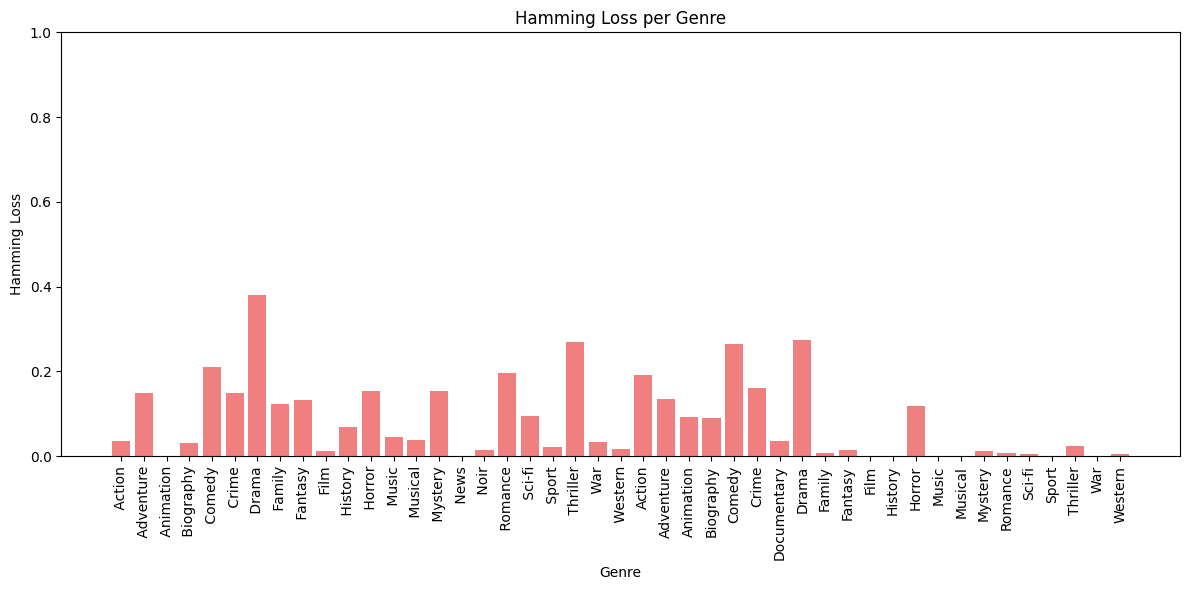

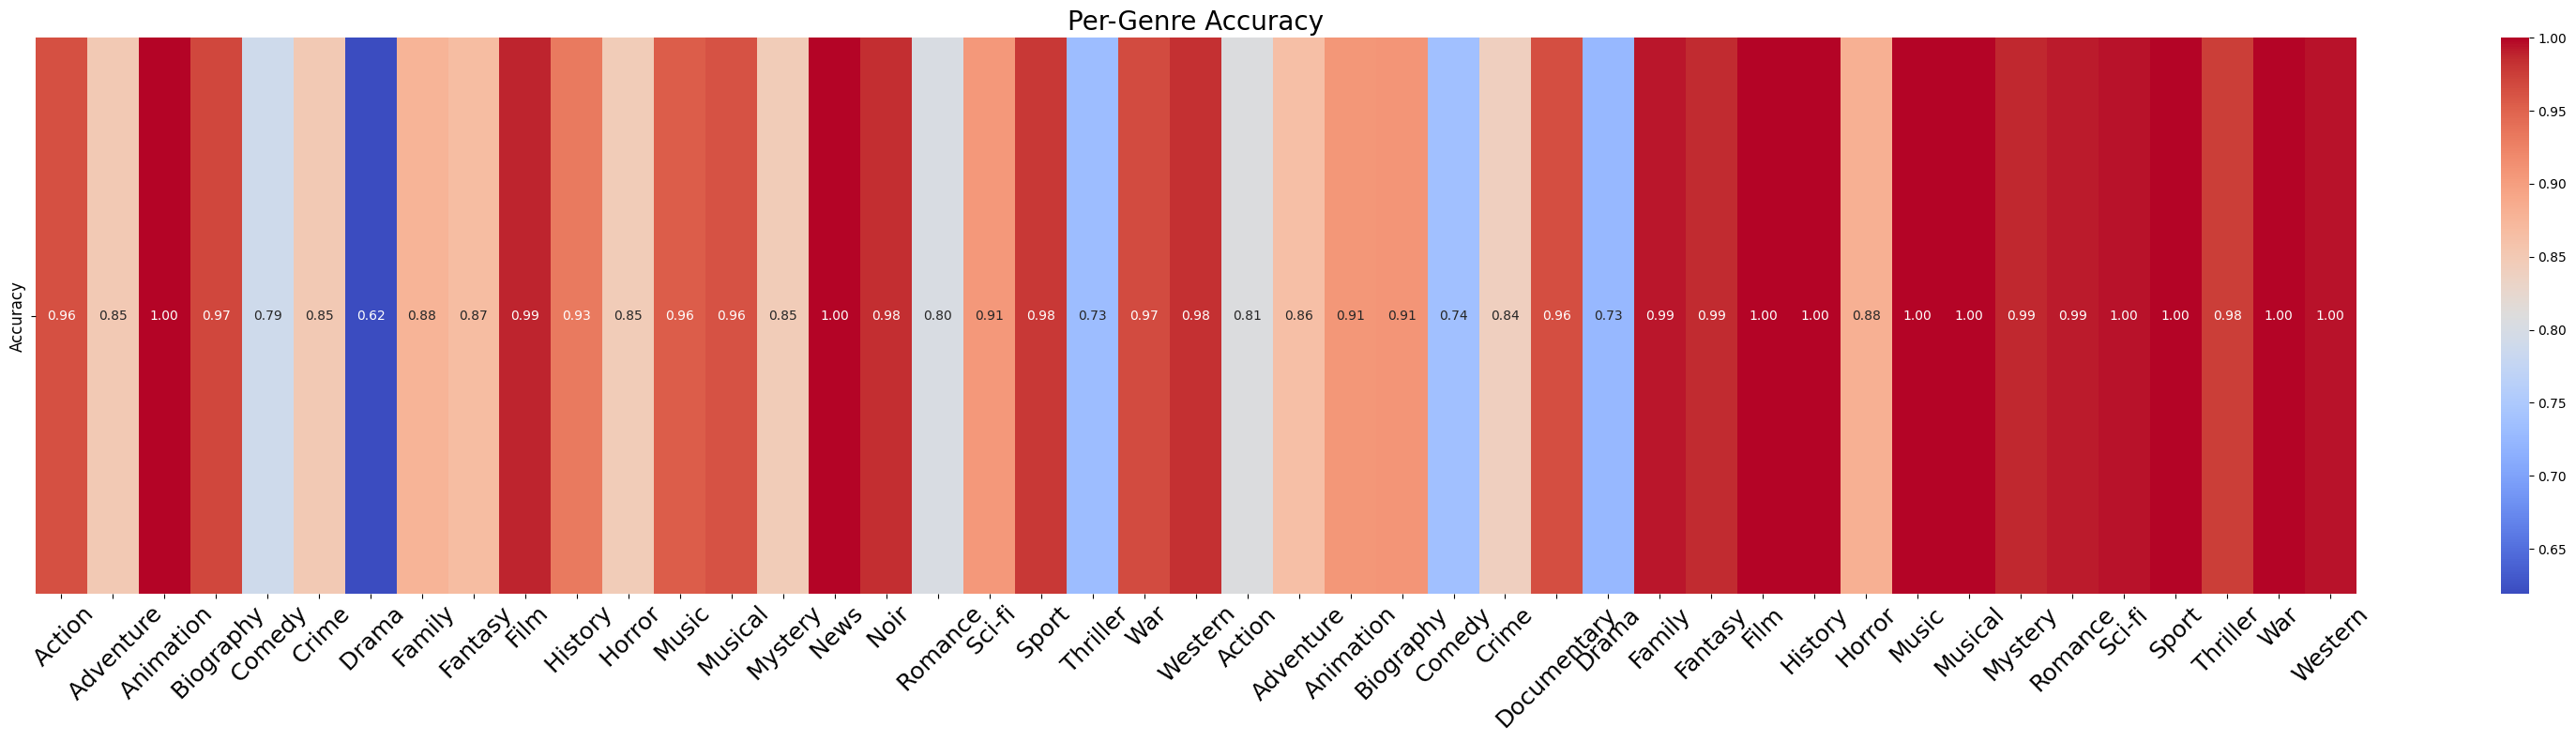




MLP Multioutput Report

Per-genre (per-label) Accuracy, F1-Score, and Hamming Loss:
------------------------------------------------------------
 Action               0.9865   0.1091   0.0135
 Adventure            0.9089   0.3580   0.0911
 Animation            0.9997   0.0000   0.0003
 Biography            0.9865   0.0000   0.0135
 Comedy               0.9058   0.0708   0.0942
 Crime                0.8923   0.3036   0.1077
 Drama                0.6871   0.2339   0.3129
 Family               0.9456   0.0751   0.0544
 Fantasy              0.9395   0.0519   0.0605
 Film                 0.9936   0.0000   0.0064
 History              0.9716   0.1043   0.0284
 Horror               0.9216   0.0596   0.0784
 Music                0.9724   0.1228   0.0276
 Musical              0.9854   0.0000   0.0146
 Mystery              0.9097   0.1679   0.0903
 News                 1.0000   0.0000   0.0000
 Noir                 0.9934   0.0000   0.0066
 Romance              0.8478   0.3556   0.1522
 Sci-f

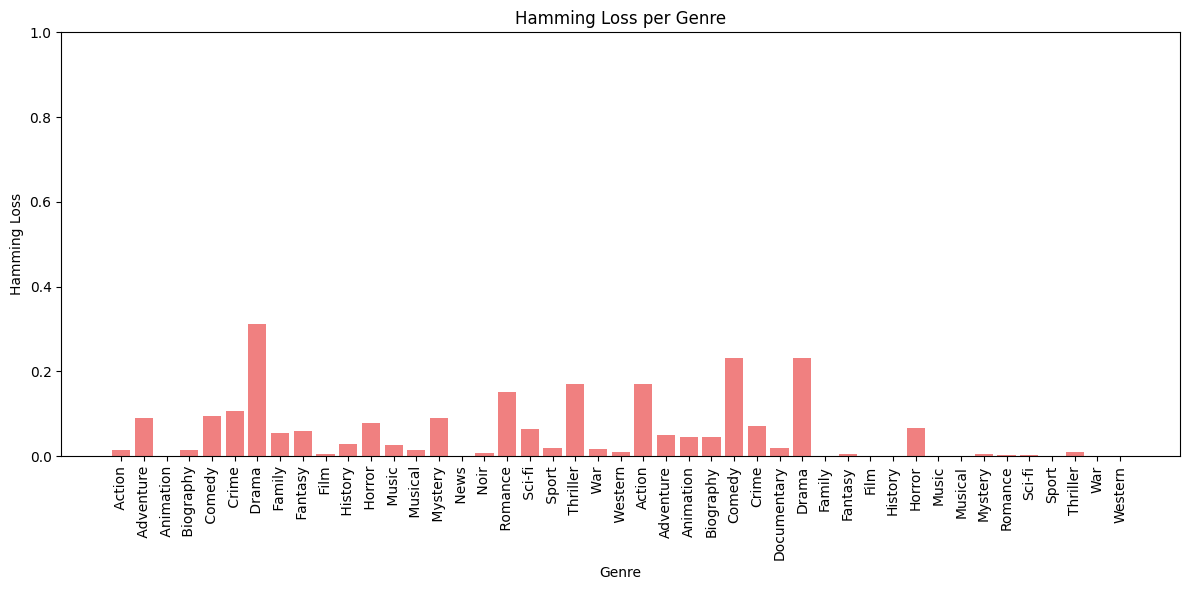

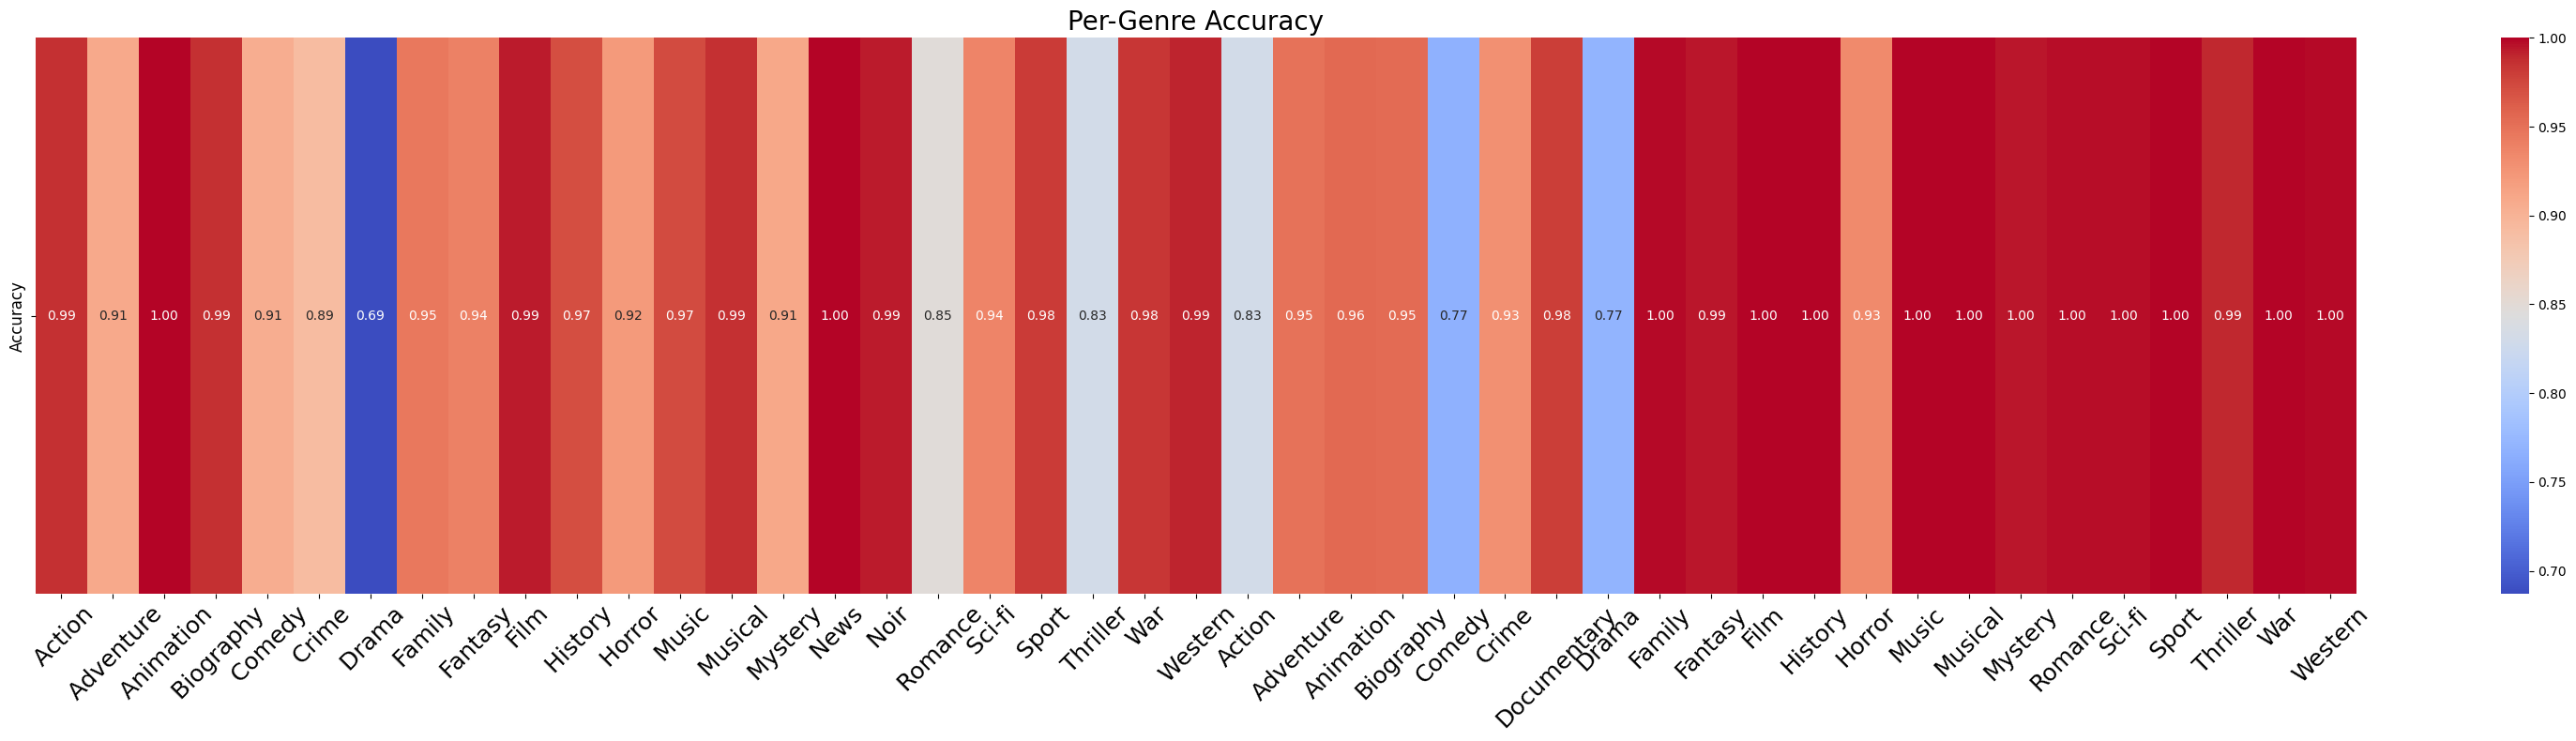





Movie Description: Paranormal investigators Ed and Lorraine Warren work to help a family terrorized by a dark presence in their farmhouse. Confronting malevolent spirits and uncovering the chilling history behind the haunting, they face their most terrifying case yet

Predicted genres:  Horror,  Mystery, Drama


In [45]:
if __name__ == "__main__":
    main()